In [1]:
import torch
import numpy as np
import pandas as pd
import time
import seaborn as sns
from tqdm import tqdm
from torch.distributions.multivariate_normal import MultivariateNormal
import pickle as pkl
import sklearn.gaussian_process.kernels as skl
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.stats import gaussian_kde
from scipy.stats import lognorm, norm

import flows
import iaf_modules
from mass_model import GP_cov, GP_log_likelihood, log_prior_GP

# Load Data

In [2]:
# Data
S2n_train = pd.read_csv("S2n_train.csv")
S2n_test = pd.read_csv("S2n_test.csv")

print(S2n_train.shape)
print(S2n_test.shape)

(1029, 15)
(120, 15)


# Training Process (single model: UNEDF1)

In [3]:
# Train a single model
model_name = "UNEDF1"
torch.manual_seed(2)
residuals = S2n_train["S2n_16"] - S2n_train[model_name]
x_train = torch.tensor(S2n_train[["Z", "N"]].to_numpy(float), dtype = torch.float)
y_train = torch.tensor(residuals.to_numpy(float).flatten(), dtype = torch.float)



mdl = flows.IAF_DSF(5, 128, 1, 8, activation=iaf_modules.softplus, num_ds_dim=16, num_ds_layers=8)
optimizer = torch.optim.Adam(mdl.parameters(), lr=0.0001, betas=(0.9, 0.999))

n_steps = 300
n_mc = 10
loss_array = np.zeros(n_steps)


time_counter = np.array(time.monotonic())

for t in tqdm(range(n_steps)):
    optimizer.zero_grad()
    zk, logdet, logPz0, context = mdl.sample(n_mc)
    losses = logPz0 - (log_prior_GP(param=zk)+GP_log_likelihood(x=x_train, y=y_train, param=zk)) - logdet
    loss_array[t] = losses.mean().item()
    loss = losses.mean()
    loss.backward()
    optimizer.step()
    time_counter = np.append(time_counter, time.monotonic())
    



100%|██████████| 300/300 [02:27<00:00,  2.03it/s]


In [4]:
# Posterior Samples
post_spl = mdl.sample(10000)[0].data
print(post_spl.shape)

torch.Size([10000, 5])


In [5]:
print(loss_array[290:300])

[803.41882324 799.37371826 801.90246582 804.70324707 799.83300781
 807.09802246 799.98962402 800.92773438 800.93908691 802.14135742]


In [6]:
sigma2_post = torch.exp(post_spl[:,0])
beta_post = post_spl[:,1]
eta_post = torch.exp(post_spl[:,2])
ls1_post = torch.exp(post_spl[:,3])
ls2_post = torch.exp(post_spl[:,4])
ls_post = torch.exp(post_spl[:,3:5])

In [7]:
# Posterior samples dictionary
posteriors_dictionary_sample = {}
posteriors_dictionary_sample['sigma'] = np.sqrt(sigma2_post.squeeze().detach().numpy())
posteriors_dictionary_sample['sigma2'] = sigma2_post.squeeze().detach().numpy()
posteriors_dictionary_sample['ls'] = ls_post.squeeze().detach().numpy()
posteriors_dictionary_sample['beta'] = beta_post.squeeze().detach().numpy()
posteriors_dictionary_sample['eta'] = eta_post.squeeze().detach().numpy()

In [9]:
# folder = "NAF_Masses_RMS_" + model_name

# if not os.path.exists(folder):
#     os.makedirs(folder)

# with open(folder + "\posterior_samples" + '.pickle', 'wb') as handle:
#     pkl.dump(posteriors_dictionary_sample, handle, protocol=pkl.HIGHEST_PROTOCOL)

/Users/zhoujiefu/anaconda3/envs/torch1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

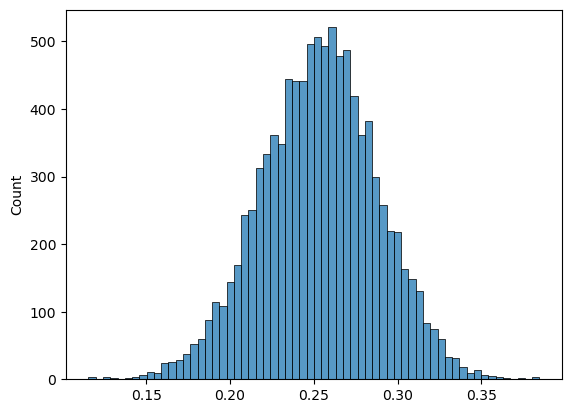

In [11]:
sns.histplot(beta_post.squeeze().detach().numpy())

/Users/zhoujiefu/anaconda3/envs/torch1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

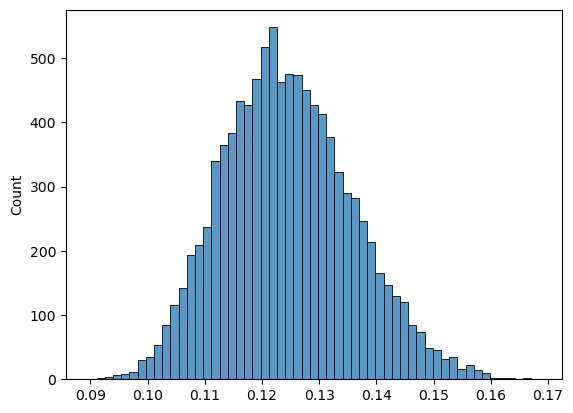

In [12]:
sns.histplot(np.sqrt(sigma2_post.squeeze().detach().numpy()))

# Prediction

In [13]:
residuals_test = S2n_test["S2n_16"] - S2n_test[model_name]
data_input_test = {"Response": residuals_test.to_numpy(float).flatten(), "X": S2n_test[["Z", "N"]].to_numpy(float)}

residuals_train = S2n_train["S2n_16"] - S2n_train[model_name]
data_input_train = {"Response": residuals_train.to_numpy(float).flatten(), "X": S2n_train[["Z", "N"]].to_numpy(float)}

In [14]:
n_sample = 10000 # number of posterior samples
n_test = data_input_test["Response"].shape[0]
n_train = data_input_train["Response"].shape[0]
X = np.concatenate([data_input_test['X'], data_input_train['X']])
post_samples = {}
post_samples['NAF'] = np.zeros((data_input_test["Response"].shape[0], n_sample))

In [42]:
posteriors_dictionary_sample['eta']

array([0.53917587, 0.5297949 , 0.5732311 , ..., 0.56425923, 0.57111484,
       0.59214514], dtype=float32)

In [15]:
for i in tqdm(range(n_sample), desc= 'NAF'):
    eta = float(posteriors_dictionary_sample['eta'][-(i + 1)])
    ls = posteriors_dictionary_sample['ls'][-(i + 1)]
    sigma2 = float(posteriors_dictionary_sample['sigma2'][-(i + 1)])
    beta = float(posteriors_dictionary_sample['beta'][-(i + 1)])
    kernel_base = eta ** 2 * skl.RBF(length_scale = ls)
    K = kernel_base(X)
    K11 = K[:n_test,:n_test] + np.diag([sigma2] * n_test)
    K22 = K[n_test:,n_test:] + np.diag([sigma2] * n_train)
    K12 = K[:n_test,n_test:]
    
    mean_pred = np.repeat(beta,n_test)[:,None]
    mean_old = np.repeat(beta,n_train)[:,None]
    
    m_pred = mean_pred + np.dot(K12, np.linalg.solve(K22, data_input_train["Response"][:,None] - mean_old))
    K_pred = K11 - np.dot(K12, np.linalg.solve(K22, K12.T))
    post_samples['NAF'][:,i] = np.random.multivariate_normal(mean = m_pred.flatten(), cov = K_pred)

NAF: 100%|██████████| 10000/10000 [14:31<00:00, 11.47it/s]


In [17]:
print("NAF VBMA:")
print(np.sqrt(np.mean((data_input_test["Response"] - np.mean(post_samples['NAF'], axis = 1)) ** 2)))

NAF VBMA:
0.4116091296199642


In [18]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
NAF_cov = []
for alpha in alphas:
    print("Alpha------------------    " + str(1 - alpha))

    credible_int = {}
    credible_int["NAF"] = np.zeros((n_test, 2))

    credible_int["NAF"][:,0] = np.quantile(post_samples["NAF"], alpha / 2, axis =1)
    credible_int["NAF"][:,1] = np.quantile(post_samples["NAF"],1 - alpha / 2, axis =1)


   
    NAF_cov = NAF_cov + [np.sum((data_input_test["Response"] >= credible_int["NAF"][:,0]) & (data_input_test["Response"] <= credible_int["NAF"][:,1])) / n_test] 
    print("NAF predictive coverage: " + str(np.sum((data_input_test["Response"] >= credible_int["NAF"][:,0]) & (data_input_test["Response"] <= credible_int["NAF"][:,1])) / n_test))

Alpha------------------    0.9
NAF predictive coverage: 0.9333333333333333
Alpha------------------    0.8
NAF predictive coverage: 0.9
Alpha------------------    0.7
NAF predictive coverage: 0.7916666666666666
Alpha------------------    0.6
NAF predictive coverage: 0.75
Alpha------------------    0.5
NAF predictive coverage: 0.6833333333333333
Alpha------------------    0.4
NAF predictive coverage: 0.5666666666666667
Alpha------------------    0.30000000000000004
NAF predictive coverage: 0.5
Alpha------------------    0.19999999999999996
NAF predictive coverage: 0.375
Alpha------------------    0.09999999999999998
NAF predictive coverage: 0.15


# VI

In [19]:
# Loading posterior distributions
with open("posterior_samples"  + '.pickle', 'rb') as handle:
    posteriors_VI = pkl.load(handle)

In [21]:
post_samples['VBMA'] = np.zeros((data_input_test["Response"].shape[0], n_sample))

for i in tqdm(range(n_sample), desc= 'VBMA'):
    eta = float(posteriors_VI['eta'][-(i + 1)])
    ls = posteriors_VI['ls'][-(i + 1)]
    sigma2 = float(posteriors_VI['sigma2'][-(i + 1)])
    beta = float(posteriors_VI['beta'][-(i + 1)])
    kernel_base = eta ** 2 * skl.RBF(length_scale = ls)
    K = kernel_base(X)
    K11 = K[:n_test,:n_test] + np.diag([sigma2] * n_test)
    K22 = K[n_test:,n_test:] + np.diag([sigma2] * n_train)
    K12 = K[:n_test,n_test:]
    
    mean_pred = np.repeat(beta,n_test)[:,None]
    mean_old = np.repeat(beta,n_train)[:,None]
    
    m_pred = mean_pred + np.dot(K12, np.linalg.solve(K22, data_input_train["Response"][:,None] - mean_old))
    K_pred = K11 - np.dot(K12, np.linalg.solve(K22, K12.T))
    post_samples['VBMA'][:,i] = np.random.multivariate_normal(mean = m_pred.flatten(), cov = K_pred)
    

VBMA: 100%|██████████| 10000/10000 [13:59<00:00, 11.91it/s]


In [22]:
print("RMSE VBMA:")
print(np.sqrt(np.mean((data_input_test["Response"] - np.mean(post_samples['VBMA'], axis = 1)) ** 2)))

RMSE VBMA:
0.4125760088926204


In [25]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
NAF_cov = []
VBMA_cov = []
for alpha in alphas:
    print("Alpha------------------    " + str(1 - alpha))

    credible_int = {}
    credible_int["NAF"] = np.zeros((n_test, 2))
    credible_int["VBMA"] = np.zeros((n_test, 2))

    credible_int["NAF"][:,0] = np.quantile(post_samples["NAF"], alpha / 2, axis =1)
    credible_int["NAF"][:,1] = np.quantile(post_samples["NAF"],1 - alpha / 2, axis =1)
    credible_int["VBMA"][:,0] = np.quantile(post_samples["VBMA"], alpha / 2, axis =1)
    credible_int["VBMA"][:,1] = np.quantile(post_samples["VBMA"],1 - alpha / 2, axis =1)


    # Predictive coverage:
    NAF_cov = NAF_cov + [np.sum((data_input_test["Response"] >= credible_int["NAF"][:,0]) & (data_input_test["Response"] <= credible_int["NAF"][:,1])) / n_test] 
    print("MCMC predictive coverage: " + str(np.sum((data_input_test["Response"] >= credible_int["NAF"][:,0]) & (data_input_test["Response"] <= credible_int["NAF"][:,1])) / n_test))
    
    VBMA_cov = VBMA_cov + [np.sum((data_input_test["Response"] >= credible_int["VBMA"][:,0]) & (data_input_test["Response"] <= credible_int["VBMA"][:,1])) / n_test] 
    print("VBMA predictive coverage: " + str(np.sum((data_input_test["Response"] >= credible_int["VBMA"][:,0]) & (data_input_test["Response"] <= credible_int["VBMA"][:,1])) / n_test))

Alpha------------------    0.9
MCMC predictive coverage: 0.9333333333333333
VBMA predictive coverage: 0.9333333333333333
Alpha------------------    0.8
MCMC predictive coverage: 0.9
VBMA predictive coverage: 0.8833333333333333
Alpha------------------    0.7
MCMC predictive coverage: 0.7916666666666666
VBMA predictive coverage: 0.7916666666666666
Alpha------------------    0.6
MCMC predictive coverage: 0.75
VBMA predictive coverage: 0.7416666666666667
Alpha------------------    0.5
MCMC predictive coverage: 0.6833333333333333
VBMA predictive coverage: 0.675
Alpha------------------    0.4
MCMC predictive coverage: 0.5666666666666667
VBMA predictive coverage: 0.575
Alpha------------------    0.30000000000000004
MCMC predictive coverage: 0.5
VBMA predictive coverage: 0.5083333333333333
Alpha------------------    0.19999999999999996
MCMC predictive coverage: 0.375
VBMA predictive coverage: 0.39166666666666666
Alpha------------------    0.09999999999999998
MCMC predictive coverage: 0.15
VBMA

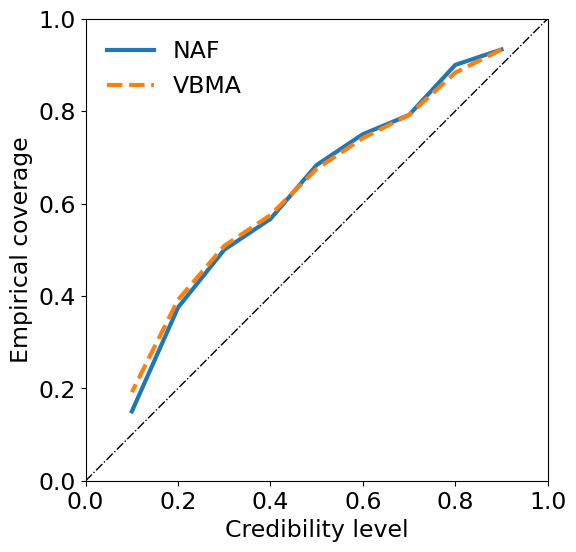

In [27]:
fig = plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size': 17})
gs = gridspec.GridSpec(1, 1, hspace = 0.001, wspace = 0.001)
lw = 3
ref = np.linspace(0, 1, num = 100)

ax = plt.subplot(gs[0])
ax.plot(1 - np.array(alphas), NAF_cov, lw =lw, label = r"NAF")
ax.plot(1 - np.array(alphas), VBMA_cov, lw =lw, linestyle = '--', label = r"VBMA")
ax.plot(ref, ref, lw =1, linestyle = 'dashdot', color = 'black')
ax.set_aspect('equal', adjustable='box')
ax.set_ylim([0,1])
ax.set_xlim([0,1])
ax.set_xlabel(r"Credibility level")
ax.set_ylabel("Empirical coverage")
ax.legend(frameon=False, loc='upper left')
plt.savefig("Mass_coverage_full_RMS.pdf", dpi=500,bbox_inches='tight')
plt.show()

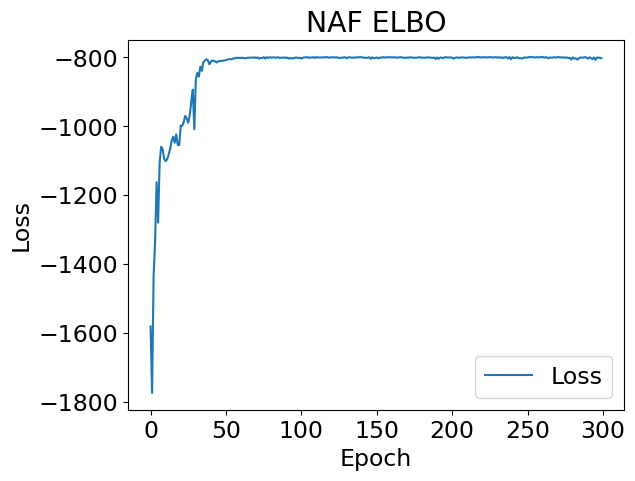

In [33]:
# Plotting the ELBO for NAF
plt.plot(-loss_array, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('NAF ELBO')
plt.legend()
plt.show()

In [34]:
beta_naf = posteriors_dictionary_sample['beta']
beta_vi = posteriors_VI['beta']

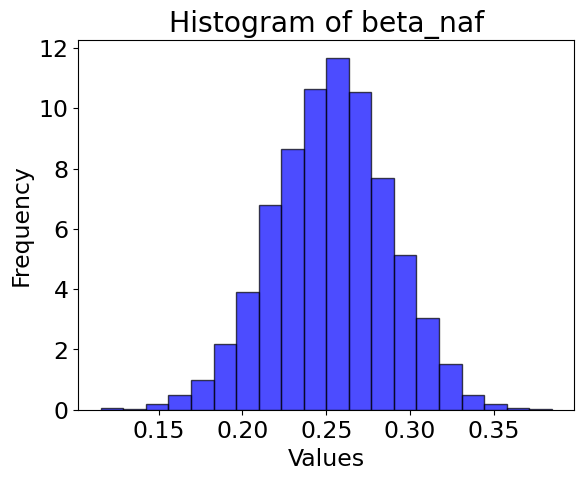

In [37]:
# Plotting the histogram
plt.hist(beta_naf, bins=20, density=True, alpha=0.7, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of beta_naf')

# Show the plot
plt.show()

/Users/zhoujiefu/anaconda3/envs/torch1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhoujiefu/anaconda3/envs/torch1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


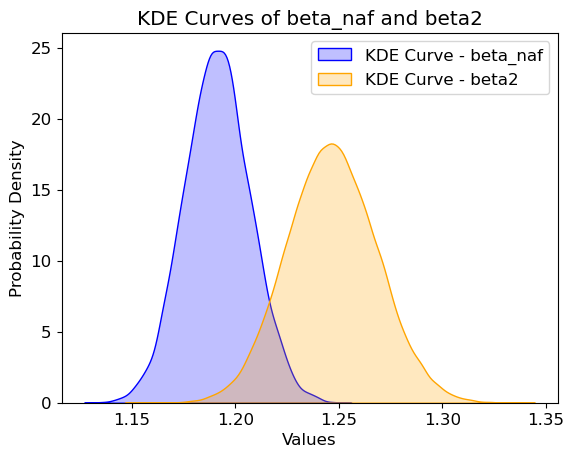

In [91]:
# Plotting the KDE curves for both arrays
sns.kdeplot(posteriors_dictionary_sample['ls'][:,0], fill=True, color='blue', label='KDE Curve - beta_naf')
sns.kdeplot(posteriors_VI['ls'][:,0], fill=True, color='orange', label='KDE Curve - beta2')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('KDE Curves of beta_naf and beta2')

# Show the legend and plot
plt.legend()
plt.show()

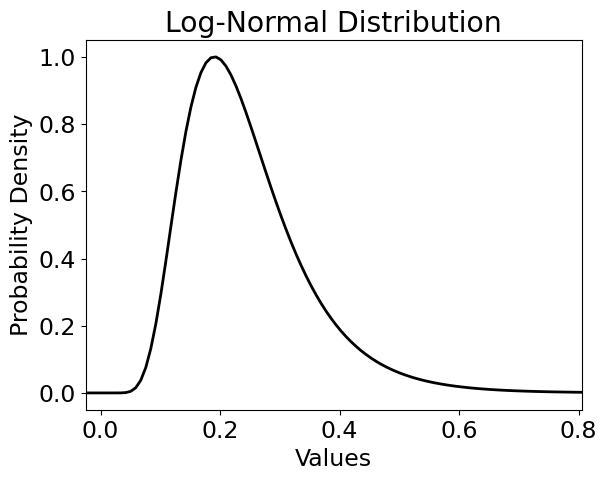

In [73]:
sigma2_naf = posteriors_dictionary_sample['ls'][:,1]

# Plotting the log-normal probability density function (PDF) curve
xmin, xmax = plt.xlim([-0.025, 0.805])
x = np.linspace(xmin, xmax, 100)
mu, sigma = np.log(sigma2_naf).mean(), np.log(sigma2_naf).std()
p = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
plt.plot(x, p/np.max(p), 'k', linewidth=2)

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('Log-Normal Distribution')

# Show the plot
plt.show()

In [68]:
posteriors_dictionary_sample['ls'][:,1]

array([0.2997449 , 0.2932648 , 0.12732849, ..., 0.13777897, 0.29705667,
       0.17083238], dtype=float32)

In [78]:
#### NAF ####
range_plot = [-1,1]
n_points = 1000
x = np.linspace(range_plot[0], range_plot[1], num = n_points)

# beta
beta_post_naf = posteriors_dictionary_sample['beta']
mu, sigma = np.mean(beta_post_naf), np.std(beta_post_naf)
p_beta_naf = norm.pdf(x, scale=sigma, loc=mu)


# sigma2
sigma2_post_naf = posteriors_dictionary_sample['sigma2']
mu, sigma = np.log(sigma2_post_naf).mean(), np.log(sigma2_post_naf).std()
p_sigma2_NAF = lognorm.pdf(x, s=sigma, scale=np.exp(mu))


# eta
eta_post_naf = posteriors_dictionary_sample['eta']
mu, sigma = np.log(eta_post_naf).mean(), np.log(eta_post_naf).std()
p_eta_NAF = lognorm.pdf(x, s=sigma, scale=np.exp(mu))


# ls0
ls0_post_naf = posteriors_dictionary_sample['ls'][:,0]
mu, sigma = np.log(ls0_post_naf).mean(), np.log(ls0_post_naf).std()
p_ls0_NAF = lognorm.pdf(x, s=sigma, scale=np.exp(mu))


# ls1
ls1_post_naf = posteriors_dictionary_sample['ls'][:,1]
mu, sigma = np.log(ls1_post_naf).mean(), np.log(ls1_post_naf).std()
p_ls1_NAF = lognorm.pdf(x, s=sigma, scale=np.exp(mu))


In [90]:
np.mean(ls0_post_naf), np.std(ls0_post_naf), np.log(ls1_post_naf).std()

(1.1911975, 0.015911885, 0.40650496)

In [79]:
#### VI ####
# beta
beta_post_vi = posteriors_VI['beta']
mu, sigma = np.mean(beta_post_vi), np.std(beta_post_vi)
p_beta_vi = norm.pdf(x, scale=sigma, loc=mu)


# sigma2
sigma2_post_vi = posteriors_VI['sigma2']
mu, sigma = np.log(sigma2_post_vi).mean(), np.log(sigma2_post_vi).std()
p_sigma2_vi = lognorm.pdf(x, s=sigma, scale=np.exp(mu))


# eta
eta_post_vi = posteriors_VI['eta']
mu, sigma = np.log(eta_post_vi).mean(), np.log(eta_post_vi).std()
p_eta_vi = lognorm.pdf(x, s=sigma, scale=np.exp(mu))


# ls0
ls0_post_vi = posteriors_VI['ls'][:,0]
mu, sigma = np.log(ls0_post_vi).mean(), np.log(ls0_post_vi).std()
p_ls0_vi = lognorm.pdf(x, s=sigma, scale=np.exp(mu))


# ls1
ls1_post_vi = posteriors_VI['ls'][:,1]
mu, sigma = np.log(ls1_post_vi).mean(), np.log(ls1_post_vi).std()
p_ls1_vi = lognorm.pdf(x, s=sigma, scale=np.exp(mu))

In [85]:
posteriors_VI['ls'][:,1]

array([0.37796715, 0.6942565 , 0.29558313, ..., 0.4768332 , 0.44640586,
       0.29242823], dtype=float32)

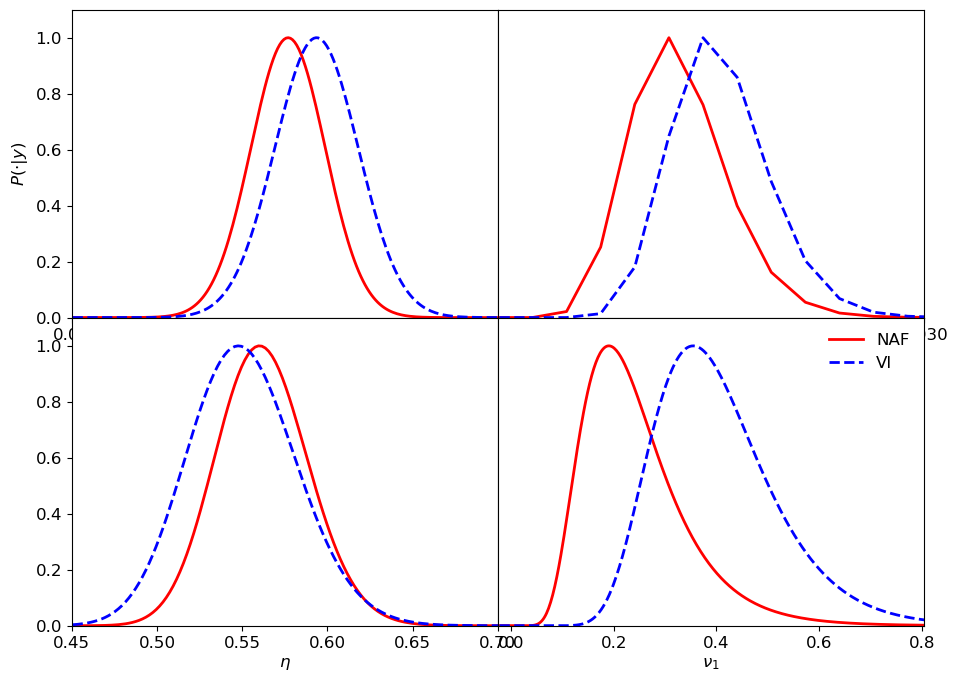

In [92]:
# Plot settings
lw_v = 4
lw_dens = 2
dens_col = "black"
line_col = "black"

fig = plt.figure(figsize=(11, 8))
plt.rcParams.update({'font.size': 12})
gs = gridspec.GridSpec(2, 2, hspace = 0.001, wspace = 0.001)


#### beta ###
ax = plt.subplot(gs[0])
ax.plot(x, p_beta_naf/max(p_beta_naf), lw=lw_dens, color='red')
ax.plot(x, p_beta_vi/max(p_beta_vi), lw=lw_dens, color='blue', linestyle='--')
ax.set_ylim([0,1.1])
ax.set_xlim([0.050,0.450])
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$P(\cdot|y)$")


#### sigma2 ###
ax = plt.subplot(gs[1])
ax.plot(x, p_sigma2_NAF/max(p_sigma2_NAF), lw=lw_dens, color='red')
ax.plot(x, p_sigma2_vi/max(p_sigma2_vi), lw=lw_dens, color='blue', linestyle='--')
ax.set_ylim([0,1.1])
ax.set_xlim([0.005,0.030])
ax.set_yticks([])
ax.set_xlabel(r"$\sigma^2$")


#### eta ###
ax = plt.subplot(gs[2])
ax.plot(x, p_eta_NAF/max(p_eta_NAF), lw=lw_dens, color='red')
ax.plot(x, p_eta_vi/max(p_eta_vi), lw=lw_dens, color='blue', linestyle='--')
ax.set_ylim([0,1.1])
ax.set_xlim([0.450,0.700])
ax.set_xlabel(r"$\eta$")


#### ls1 ###
ax = plt.subplot(gs[3])
ax.plot(x, p_ls1_NAF/max(p_ls1_NAF), lw=lw_dens, color='red', label="NAF")
ax.plot(x, p_ls1_vi/max(p_ls1_vi), lw=lw_dens, color='blue', linestyle='--', label="VI")
ax.set_ylim([0,1.1])
ax.set_xlim([-0.025, 0.805])
ax.set_yticks([])
ax.set_xlabel(r"$\nu_1$")
ax.legend(frameon=False)

# Display the plot
plt.show()


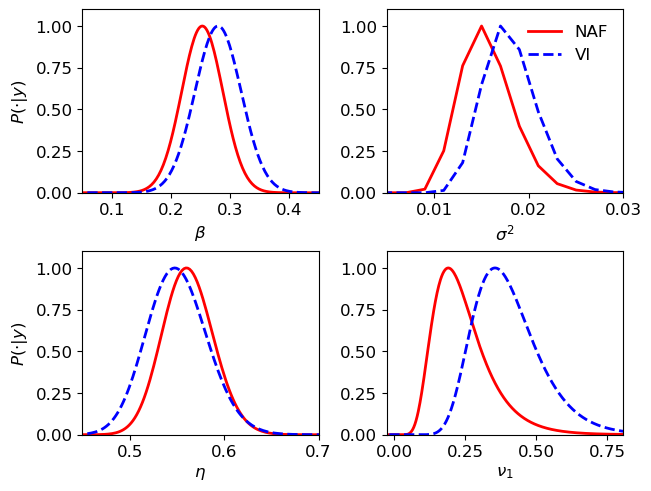

In [93]:
fig2 = plt.figure(constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig2)

#### beta ###
ax1 = fig2.add_subplot(spec2[0, 0])
ax1.plot(x, p_beta_naf/max(p_beta_naf), lw=lw_dens, color='red')
ax1.plot(x, p_beta_vi/max(p_beta_vi), lw=lw_dens, color='blue', linestyle='--')
ax1.set_ylim([0,1.1])
ax1.set_xlim([0.050,0.450])
ax1.set_xlabel(r"$\beta$")
ax1.set_ylabel(r"$P(\cdot|y)$")


#### sigma2 ###
ax2 = fig2.add_subplot(spec2[0, 1])
ax2.plot(x, p_sigma2_NAF/max(p_sigma2_NAF), lw=lw_dens, color='red', label="NAF")
ax2.plot(x, p_sigma2_vi/max(p_sigma2_vi), lw=lw_dens, color='blue', linestyle='--', label="VI")
ax2.set_ylim([0,1.1])
ax2.set_xlim([0.005,0.030])
ax2.set_xlabel(r"$\sigma^2$")
ax2.legend(frameon=False)


#### eta ###
ax3 = fig2.add_subplot(spec2[1, 0])
ax3.plot(x, p_eta_NAF/max(p_eta_NAF), lw=lw_dens, color='red')
ax3.plot(x, p_eta_vi/max(p_eta_vi), lw=lw_dens, color='blue', linestyle='--')
ax3.set_ylim([0,1.1])
ax3.set_xlim([0.450,0.700])
ax3.set_xlabel(r"$\eta$")
ax3.set_ylabel(r"$P(\cdot|y)$")


#### ls1 ###
ax4 = fig2.add_subplot(spec2[1, 1])
ax4.plot(x, p_ls1_NAF/max(p_ls1_NAF), lw=lw_dens, color='red')
ax4.plot(x, p_ls1_vi/max(p_ls1_vi), lw=lw_dens, color='blue', linestyle='--')
ax4.set_ylim([0,1.1])
ax4.set_xlim([-0.025, 0.805])
ax4.set_xlabel(r"$\nu_1$")


# Display the plot
plt.show()